# Big 5 Earnings Call Sentiment Analysis

## Overview

This notebook compares sentiment across multiple banks' earnings calls using two complementary methods:

Baseline Method:
- In our baseline method we count positive and negative words in the script. The list or "true source" of positive and negative words come from the Loughran-McDonald financial dictionary. Refer to documentation for more details on the dictionary.
- We score words as a percentage: (Positive words - Negative words) / Total words × 100
- Example: +2.5% means 2.5% more positive than negative words

FinBERT Method:
- ML model that analyzes complete sentences and paragraphs
- For each page, outputs probabilities: Positive, Negative, Neutral
- Score is average net score: Average(Positive Probability - Negative Probability)

## Step 1: Configure Banks to Analyze

In [1]:
banks_to_analyze = [
    {
        'name': 'Scotiabank',
        'url': 'https://www.scotiabank.com/content/dam/scotiabank/corporate/quarterly-reports/2025/q1/BNS-T_Transcript_2025-02-25.pdf'
    },
    {
        'name': 'RBC',
        'url': 'https://www.rbc.com/investor-relations/_assets-custom/pdf/2025q1speech.pdf'
    },
    {
        'name': 'TD Bank',
        'url': 'https://www.td.com/content/dam/tdcom/canada/about-td/pdf/quarterly-results/2025/q1/2025-q1-td-transcript.pdf'
    }
]

print(f"Configured {len(banks_to_analyze)} banks for analysis")

Configured 3 banks for analysis


## Step 2: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from pathlib import Path
from pypdf import PdfReader
import re
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from collections import Counter
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

## Step 3: Load Analysis Resources

In [3]:
# Load Loughran-McDonald dictionary
lm_dict = pd.read_csv("Loughran-McDonald_MasterDictionary_1993-2024.csv")
lm_dict['word_lower'] = lm_dict['Word'].str.lower()
positive_words_set = set(lm_dict[lm_dict['Positive'] != 0]['word_lower'].tolist())
negative_words_set = set(lm_dict[lm_dict['Negative'] != 0]['word_lower'].tolist())

print(f"Loaded {len(positive_words_set):,} positive words")
print(f"Loaded {len(negative_words_set):,} negative words")

Loaded 354 positive words
Loaded 2,355 negative words


In [4]:
# Load stopwords
with open("stopwords.txt", 'r') as f:
    stopwords_set = set(word.strip().lower() for word in f.readlines())

print(f"Loaded {len(stopwords_set):,} stopwords")

Loaded 121 stopwords


In [5]:
# Load FinBERT model
print("Loading FinBERT model...")
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
print("FinBERT model loaded")

Loading FinBERT model...
FinBERT model loaded


## Step 4: Define Processing Functions

In [6]:
def clean_financial_text(text):
    """Normalize text: lowercase, remove punctuation, collapse whitespace"""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = ' '.join(text.split())
    return text

def remove_stopwords(text, stopword_set):
    """Remove common words that don't carry sentiment"""
    words = text.split()
    filtered = [w for w in words if w not in stopword_set]
    return ' '.join(filtered)

def remove_boilerplate_text(text):
    """Remove page headers, footers, speaker names, and other boilerplate"""
    lines = text.split('\n')
    cleaned_lines = []
    
    for line in lines:
        line_stripped = line.strip()
        if not line_stripped:
            continue
        if re.search(r'Page\s+\d+\s+of\s+\d+', line_stripped, re.IGNORECASE):
            continue
        if 'Earnings Call Transcript' in line_stripped or 'Transcript' in line_stripped:
            continue
        if len(line_stripped) < 60 and line_stripped.isupper():
            if not any(w in line_stripped.lower() for w in ['the', 'and', 'our', 'we']):
                continue
        if (line_stripped.count(' - ') >= 2 or line_stripped.count('–') >= 2):
            if len(line_stripped) < 100 and not line_stripped.endswith('.'):
                continue
        cleaned_lines.append(line_stripped)
    
    return ' '.join(cleaned_lines)

def find_presentation_start(df):
    """Find the page where substantive content begins"""
    for idx, row in df.iterrows():
        text_upper = row['raw_text'].upper().replace(' ', '')
        if 'PRESENTATION' in text_upper or 'MANAGEMENTDISCUSSION' in text_upper:
            if 'PRESENTATION' in text_upper[:500] or 'MANAGEMENTDISCUSSION' in text_upper[:500]:
                if row['page_number'] > 1:
                    return row['page_number']
    return 1

def calculate_sentiment(text, pos_set, neg_set):
    """Dictionary method: Count positive and negative words"""
    words = text.split()
    pos_count = sum(1 for w in words if w in pos_set)
    neg_count = sum(1 for w in words if w in neg_set)
    net_sent = pos_count - neg_count
    return pos_count, neg_count, net_sent

def analyze_with_finbert(text, tokenizer, model):
    """FinBERT method: Analyze text and return probabilities"""
    tokenized = tokenizer(text, return_tensors="pt", truncation=True, 
                         max_length=512, padding=True)
    with torch.no_grad():
        outputs = model(**tokenized)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    pos_prob = probs[0][0].item()
    neg_prob = probs[0][1].item()
    neu_prob = probs[0][2].item()
    
    if pos_prob > neg_prob and pos_prob > neu_prob:
        label = 'positive'
    elif neg_prob > pos_prob and neg_prob > neu_prob:
        label = 'negative'
    else:
        label = 'neutral'
    
    net_score = pos_prob - neg_prob
    return pos_prob, neg_prob, neu_prob, label, net_score

def analyze_sentence_finbert(sentence, tokenizer, model):
    """Analyze a single sentence with FinBERT"""
    sentence = sentence.strip()
    
    if len(sentence) < 20:
        return None
    if re.search(r'Page\s+\d+\s+of\s+\d+', sentence, re.IGNORECASE):
        return None
    if 'Earnings Call Transcript' in sentence:
        return None
    if len(sentence) < 60 and sentence.count(' ') < 5:
        return None
    
    try:
        tokenized = tokenizer(sentence, return_tensors="pt", truncation=True,
                             max_length=512, padding=True)
        with torch.no_grad():
            outputs = model(**tokenized)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
        return {
            'sentence': sentence[:300],
            'positive_prob': probs[0][0].item(),
            'negative_prob': probs[0][1].item(),
            'net_score': probs[0][0].item() - probs[0][1].item()
        }
    except:
        return None

print("Functions defined")

Functions defined


## Step 5: Process All Banks

This will download transcripts, extract text, and run both sentiment analysis methods.
Processing happens silently with results stored for final comparison.

In [7]:
all_results = []
all_bank_data = {}

print("Processing banks...\n")

for i, bank_config in enumerate(banks_to_analyze, 1):
    bank_name = bank_config['name']
    bank_url = bank_config['url']
    
    print(f"{i}/{len(banks_to_analyze)}: {bank_name}")
    
    # Download PDF
    pdf_filename = f"{bank_name.replace(' ', '_')}_transcript.pdf"
    response = requests.get(bank_url, timeout=60)
    response.raise_for_status()
    Path(pdf_filename).write_bytes(response.content)
    
    # Extract text
    reader = PdfReader(pdf_filename)
    pages_data = []
    for page_num, page in enumerate(reader.pages, start=1):
        pages_data.append({
            'page_number': page_num,
            'raw_text': page.extract_text()
        })
    
    df = pd.DataFrame(pages_data)
    
    # Find substantive content and clean
    start_page = find_presentation_start(df)
    df = df[df['page_number'] >= start_page].copy()
    df['raw_text'] = df['raw_text'].apply(remove_boilerplate_text)
    df['cleaned_text'] = df['raw_text'].apply(clean_financial_text)
    df['cleaned_text'] = df['cleaned_text'].apply(lambda x: remove_stopwords(x, stopwords_set))
    df['word_count'] = df['cleaned_text'].str.split().str.len()
    
    full_raw_text = ' '.join(df['raw_text'].tolist())
    full_cleaned_text = ' '.join(df['cleaned_text'].tolist())
    
    # Dictionary analysis
    sentiment_results = df['cleaned_text'].apply(
        lambda text: calculate_sentiment(text, positive_words_set, negative_words_set)
    )
    df['dict_pos_count'] = sentiment_results.apply(lambda x: x[0])
    df['dict_neg_count'] = sentiment_results.apply(lambda x: x[1])
    df['dict_net_sent'] = sentiment_results.apply(lambda x: x[2])
    df['dict_sent_ratio'] = ((df['dict_net_sent'] / df['word_count']) * 100).fillna(0)
    
    dict_total_pos = df['dict_pos_count'].sum()
    dict_total_neg = df['dict_neg_count'].sum()
    dict_total_words = df['word_count'].sum()
    dict_overall_ratio = ((dict_total_pos - dict_total_neg) / dict_total_words) * 100
    
    # FinBERT analysis
    finbert_results = []
    for idx, row in df.iterrows():
        pos, neg, neu, lbl, net = analyze_with_finbert(
            row['raw_text'], finbert_tokenizer, finbert_model
        )
        finbert_results.append({
            'page_number': row['page_number'],
            'finbert_pos_prob': pos,
            'finbert_neg_prob': neg,
            'finbert_neu_prob': neu,
            'finbert_label': lbl,
            'finbert_net_score': net
        })
    
    finbert_df = pd.DataFrame(finbert_results)
    df = df.merge(finbert_df, on='page_number', how='left')
    
    finbert_avg_net = df['finbert_net_score'].mean()
    finbert_label_counts = df['finbert_label'].value_counts()
    
    # Store results
    all_results.append({
        'bank': bank_name,
        'dict_score': dict_overall_ratio,
        'finbert_score': finbert_avg_net,
        'dict_pos_words': dict_total_pos,
        'dict_neg_words': dict_total_neg,
        'finbert_pos_pages': finbert_label_counts.get('positive', 0),
        'finbert_neg_pages': finbert_label_counts.get('negative', 0),
        'total_pages': len(df)
    })
    
    all_bank_data[bank_name] = {'df': df}

print("\nProcessing complete")

Processing banks...

1/3: Scotiabank
2/3: RBC
3/3: TD Bank

Processing complete


In [13]:
# Create comparison table
comparison_df = pd.DataFrame(all_results)
comparison_df['dict_rank'] = comparison_df['dict_score'].rank(ascending=False).astype(int)
comparison_df['finbert_rank'] = comparison_df['finbert_score'].rank(ascending=False).astype(int)

# Display key metrics
display_df = comparison_df[[
    'bank', 'dict_score', 'dict_rank', 'finbert_score', 'finbert_rank'
]].sort_values('finbert_score', ascending=False)

print("\nSentiment Rankings:\n")
print(display_df.to_string(index=False))
print()


Sentiment Rankings:

      bank  dict_score  dict_rank  finbert_score  finbert_rank
       RBC    1.502980          2       0.579541             1
   TD Bank    1.510821          1       0.429067             2
Scotiabank    0.914047          3       0.378389             3



## First row interpretation
- There are 1.5 percentage points more positive words than negative words in the text.
- On average, sentences are 58 percentage points more likely to be positive than negative, according to the model.


## Step 7: Comparative Visualization

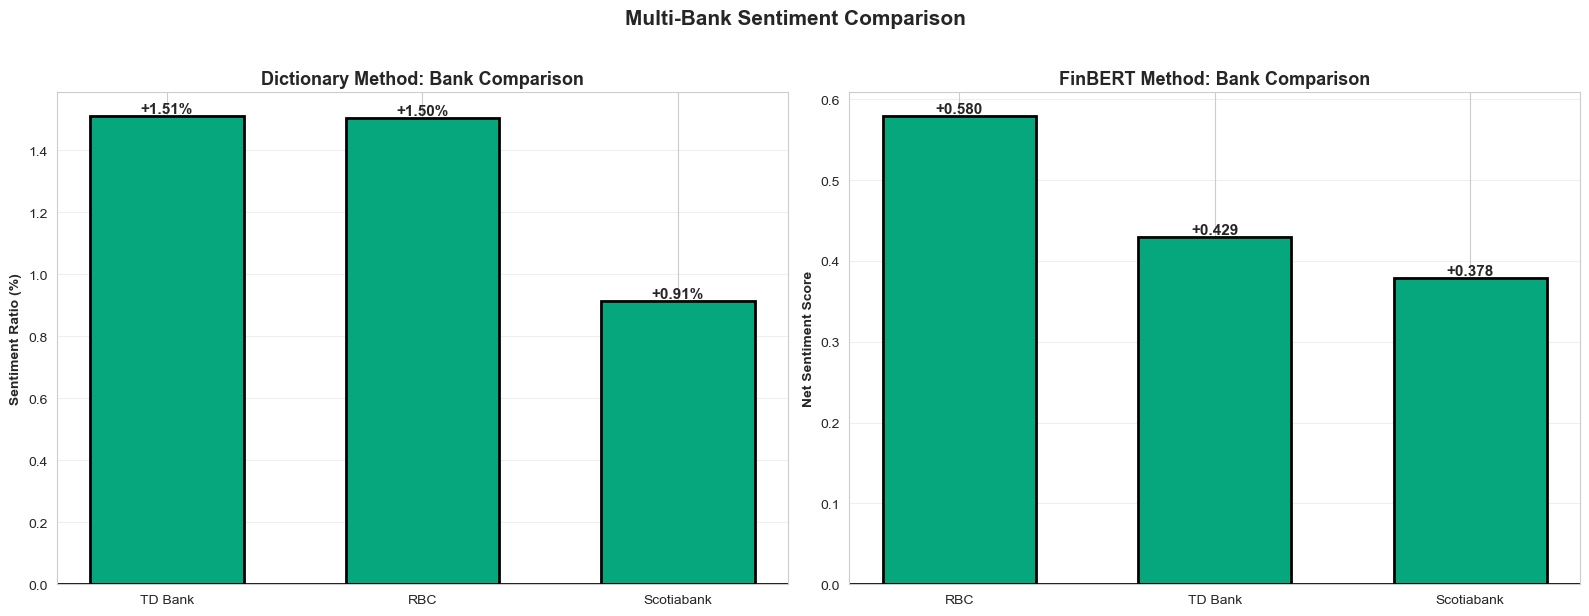

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Dictionary comparison
sorted_dict = comparison_df.sort_values('dict_score', ascending=False)
x = range(len(sorted_dict))
colors_dict = ['#06A77D' if s > 0 else '#E63946' for s in sorted_dict['dict_score']]

bars1 = ax1.bar(x, sorted_dict['dict_score'], color=colors_dict,
               edgecolor='black', linewidth=2, width=0.6)
ax1.set_xticks(x)
ax1.set_xticklabels(sorted_dict['bank'])
ax1.axhline(y=0, color='black', linewidth=2)
ax1.set_ylabel('Sentiment Ratio (%)', fontweight='bold')
ax1.set_title('Dictionary Method: Bank Comparison', fontweight='bold', fontsize=13)
ax1.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars1, sorted_dict['dict_score']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height,
            f'{score:+.2f}%', ha='center',
            va='bottom' if height > 0 else 'top',
            fontweight='bold', fontsize=11)

# FinBERT comparison
sorted_finbert = comparison_df.sort_values('finbert_score', ascending=False)
x = range(len(sorted_finbert))
colors_finbert = ['#06A77D' if s > 0 else '#E63946' for s in sorted_finbert['finbert_score']]

bars2 = ax2.bar(x, sorted_finbert['finbert_score'], color=colors_finbert,
               edgecolor='black', linewidth=2, width=0.6)
ax2.set_xticks(x)
ax2.set_xticklabels(sorted_finbert['bank'])
ax2.axhline(y=0, color='black', linewidth=2)
ax2.set_ylabel('Net Sentiment Score', fontweight='bold')
ax2.set_title('FinBERT Method: Bank Comparison', fontweight='bold', fontsize=13)
ax2.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars2, sorted_finbert['finbert_score']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height,
            f'{score:+.3f}', ha='center',
            va='bottom' if height > 0 else 'top',
            fontweight='bold', fontsize=11)

plt.suptitle('Multi-Bank Sentiment Comparison', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Step 8: Example Sentences by Bank

Top 3 most positive and most negative sentences identified by FinBERT for each bank.

In [10]:
for bank_name in comparison_df.sort_values('finbert_score', ascending=False)['bank']:
    print(f"\n{bank_name}")
    print()
    
    bank_df = all_bank_data[bank_name]['df']
    
    # Get top 3 positive pages
    top_pos_pages = bank_df.nlargest(3, 'finbert_net_score')
    
    print("Top 3 Positive Sentences:")
    pos_count = 0
    for _, page in top_pos_pages.iterrows():
        for sent in page['raw_text'].split('.'):
            result = analyze_sentence_finbert(sent, finbert_tokenizer, finbert_model)
            if result and result['net_score'] > 0:
                print(f"  {pos_count + 1}. \"{result['sentence']}\"")
                print(f"     Net: {result['net_score']:+.3f}")
                print()
                pos_count += 1
                if pos_count >= 3:
                    break
        if pos_count >= 3:
            break
    
    # Get top 3 negative pages
    top_neg_pages = bank_df.nsmallest(3, 'finbert_net_score')
    
    print("Top 3 Negative Sentences:")
    neg_count = 0
    for _, page in top_neg_pages.iterrows():
        for sent in page['raw_text'].split('.'):
            result = analyze_sentence_finbert(sent, finbert_tokenizer, finbert_model)
            if result and result['net_score'] < 0:
                print(f"  {neg_count + 1}. \"{result['sentence']}\"")
                print(f"     Net: {result['net_score']:+.3f}")
                print()
                neg_count += 1
                if neg_count >= 3:
                    break
        if neg_count >= 3:
            break
    
    print()


RBC

Top 3 Positive Sentences:
  1. "February 27, 2025/ 8:30 AM EST, RBC First Quarter 2025 Results Conference Call 4 productivity and competitiveness, including removing inter-provincial trade barriers and approving high- impact energy and infrastructure products"
     Net: +0.867

  2. "These can drive future growth opportunities, with significant benefits for Canadians"
     Net: +0.868

  3. "Amidst this uncertainty, ensuring we continue to operate with sufficient buffers takes on increased importance"
     Net: +0.928

Top 3 Negative Sentences:
  1. "These factors – many of which are beyond our control and the effects of which can be difficult to predict – include, but are not limited to: the possibility that the anticipated benefits from the acquisition of HSBC Canada are not realized, credit, market, liquidity and funding, insurance, operation"
     Net: -0.048

  2. "Additional factors that could cause actual results to differ materially from the expectations in such forward-l

## Step 9: Detailed Bank-Level Analysis

For each bank, we show:
1. Most frequent positive/negative words used
2. Sentiment progression through the earnings call


RBC - Detailed Analysis



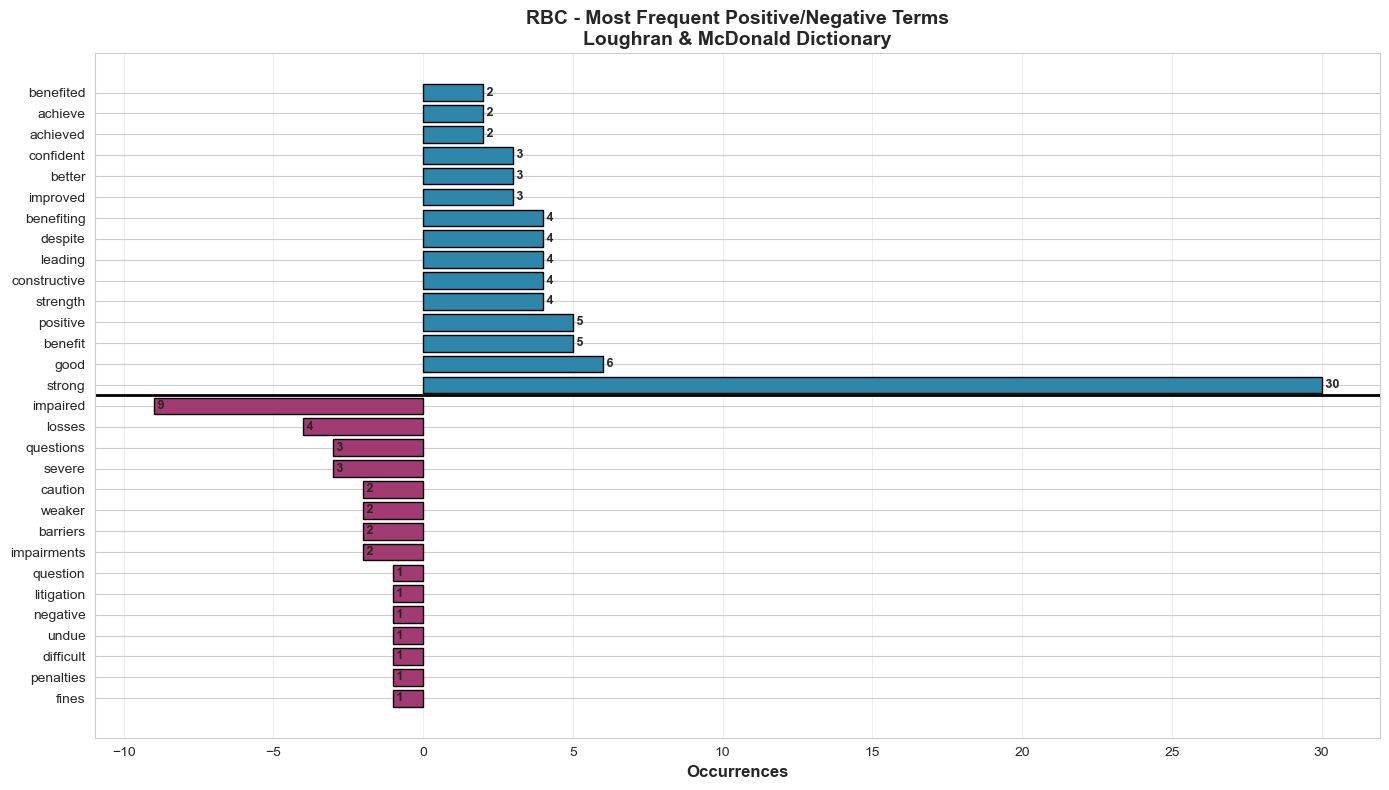

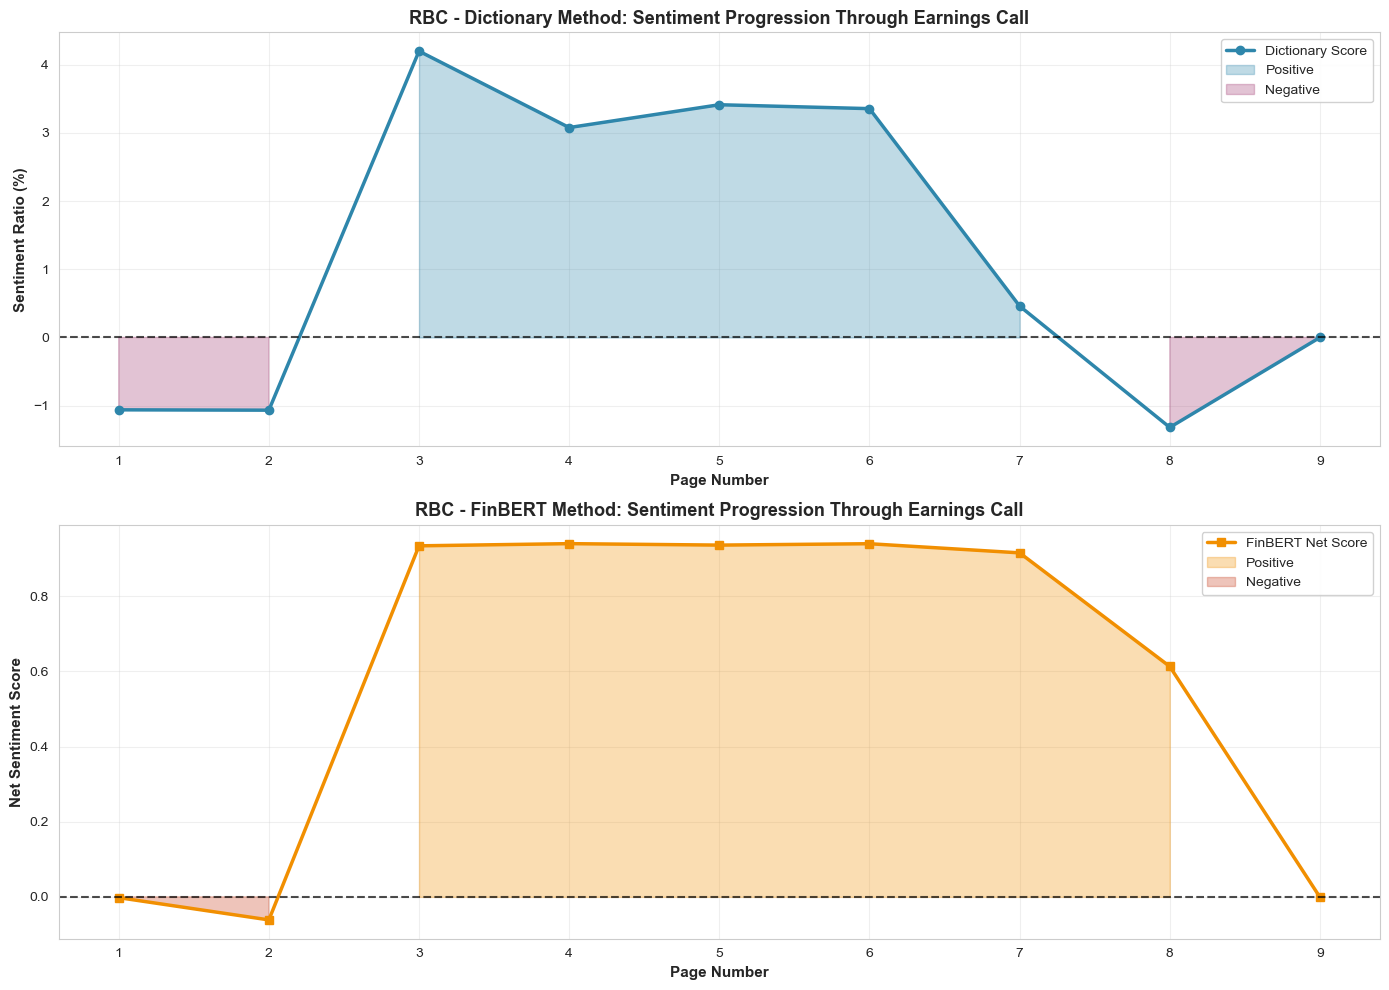


Key Insights for RBC:
  Most positive page: Page 3 (Score: 0.940)
  Most negative page: Page 1 (Score: -0.061)
  Sentiment volatility (std dev): 0.463


TD Bank - Detailed Analysis



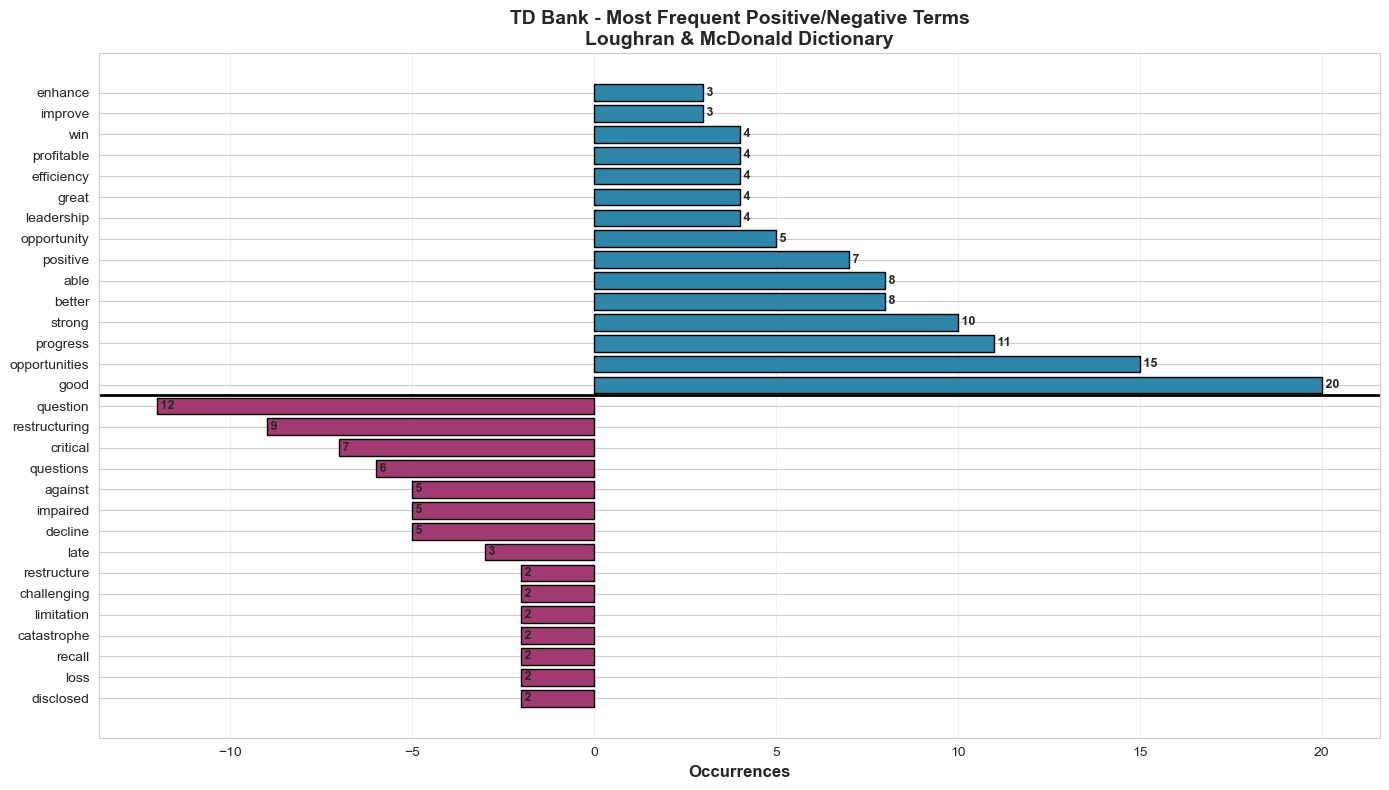

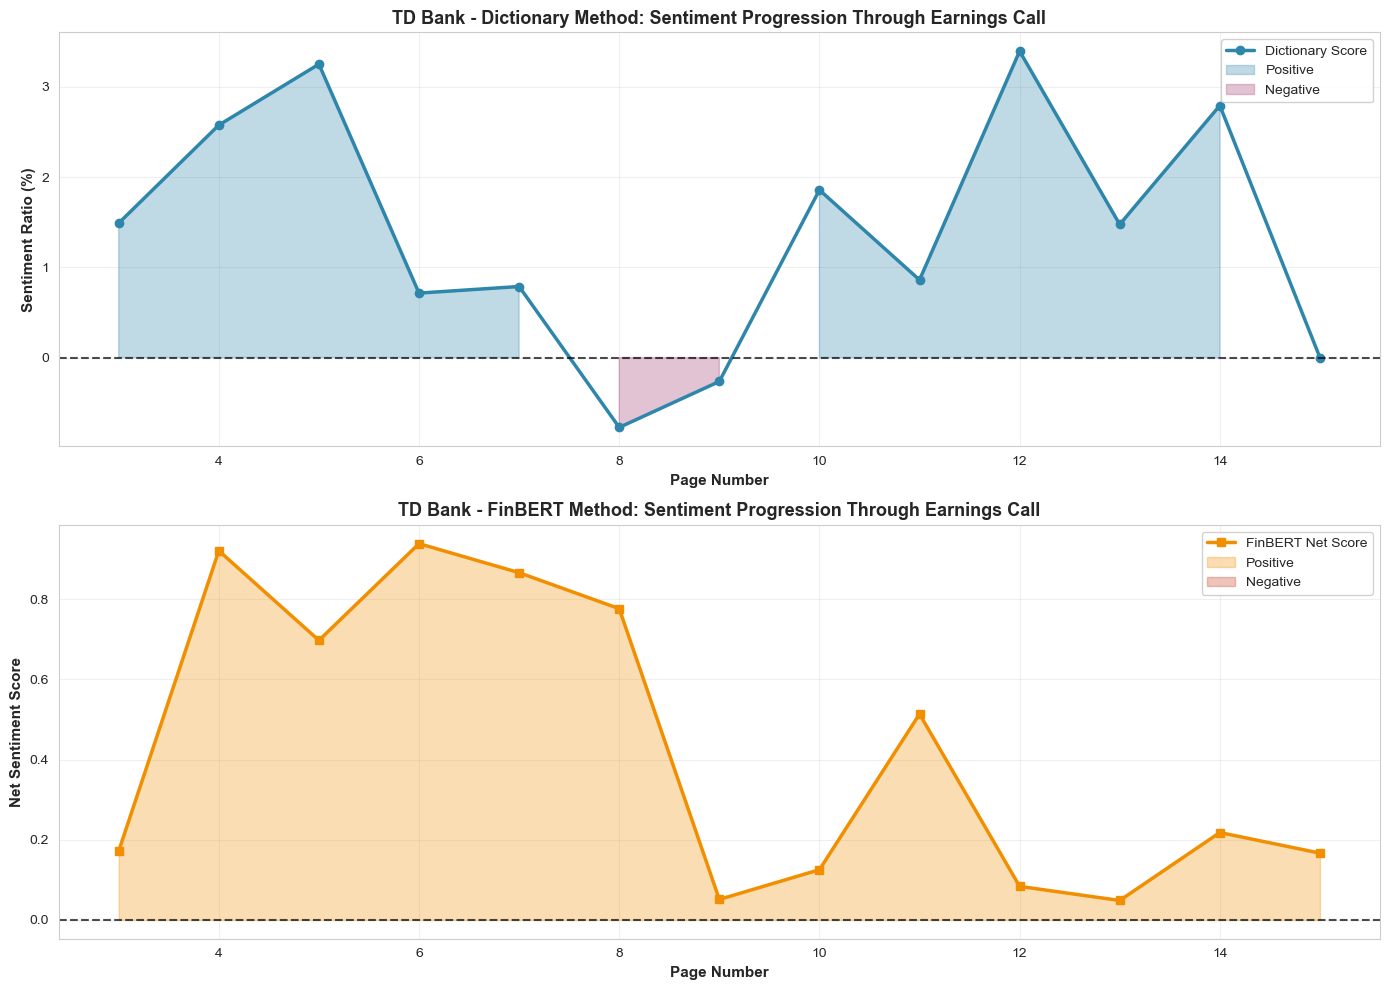


Key Insights for TD Bank:
  Most positive page: Page 3 (Score: 0.939)
  Most negative page: Page 10 (Score: 0.048)
  Sentiment volatility (std dev): 0.362


Scotiabank - Detailed Analysis



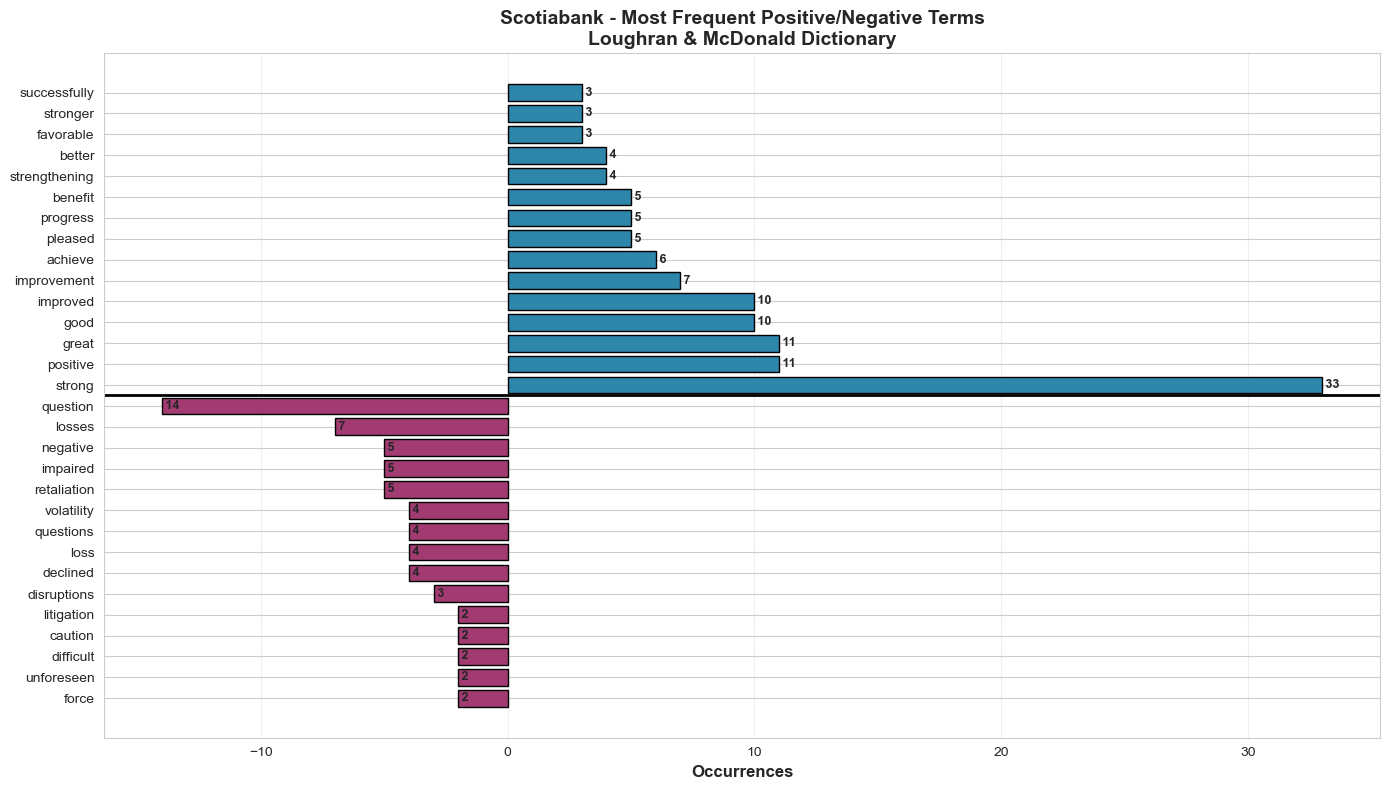

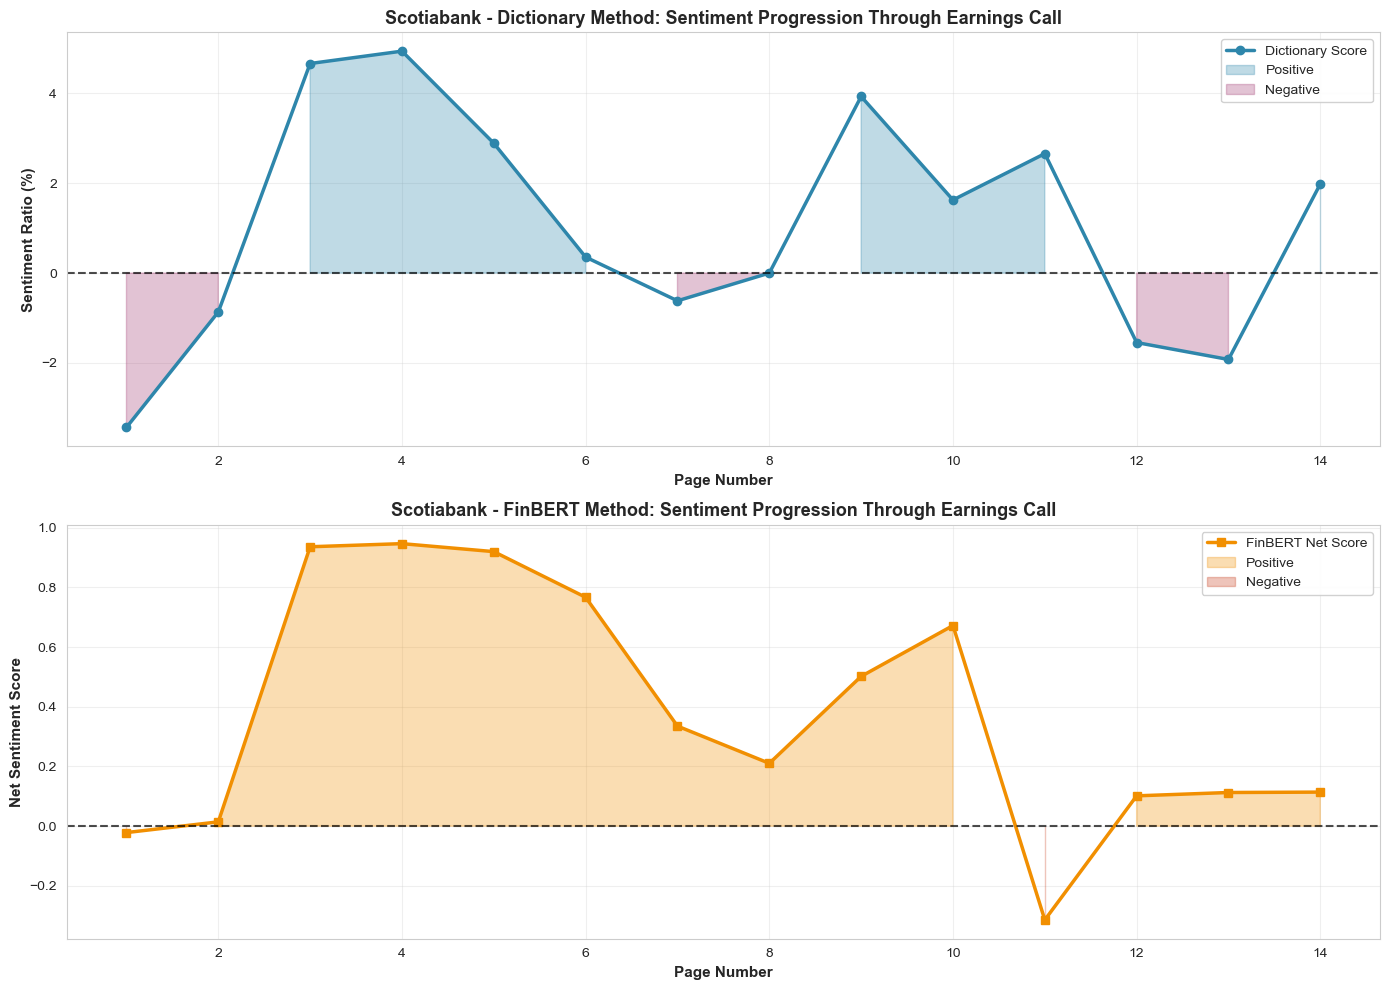


Key Insights for Scotiabank:
  Most positive page: Page 3 (Score: 0.947)
  Most negative page: Page 10 (Score: -0.314)
  Sentiment volatility (std dev): 0.411



In [11]:
for bank_name in comparison_df.sort_values('finbert_score', ascending=False)['bank']:
    print(f"\n{'='*80}")
    print(f"{bank_name} - Detailed Analysis")
    print(f"{'='*80}\n")
    
    bank_df = all_bank_data[bank_name]['df']
    full_cleaned_text = ' '.join(bank_df['cleaned_text'].tolist())
    all_words = full_cleaned_text.split()
    
    # Extract most frequent positive and negative words
    pos_words = [w for w in all_words if w in positive_words_set]
    neg_words = [w for w in all_words if w in negative_words_set]
    
    top_pos = Counter(pos_words).most_common(15)
    top_neg = Counter(neg_words).most_common(15)
    
    # Chart 1: Word Frequency Bar Chart (like Loughran-McDonald style)
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    # Prepare data
    pos_words_list = [w for w, c in top_pos]
    pos_counts = [c for w, c in top_pos]
    neg_words_list = [w for w, c in top_neg]
    neg_counts = [-c for w, c in top_neg]  # Negative for downward bars
    
    # Combine for plotting
    y_pos = list(range(len(pos_words_list)))
    y_neg = [-i-1 for i in range(len(neg_words_list))]
    
    # Plot positive words (upward bars)
    ax.barh(y_pos, pos_counts, color='#2E86AB', edgecolor='black', linewidth=1, height=0.8)
    # Plot negative words (downward bars)
    ax.barh(y_neg, neg_counts, color='#A23B72', edgecolor='black', linewidth=1, height=0.8)
    
    # Set labels
    ax.set_yticks(y_pos + y_neg)
    ax.set_yticklabels(pos_words_list + neg_words_list)
    ax.set_xlabel('Occurrences', fontweight='bold', fontsize=12)
    ax.set_title(f'{bank_name} - Most Frequent Positive/Negative Terms\nLoughran & McDonald Dictionary', 
                fontweight='bold', fontsize=14)
    ax.axhline(y=-0.5, color='black', linewidth=2)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (word, count) in enumerate(top_pos):
        ax.text(count, i, f' {count}', va='center', fontweight='bold', fontsize=9)
    for i, (word, count) in enumerate(top_neg):
        ax.text(-count, -i-1, f' {count}', va='center', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Chart 2: Sentiment Progression Through Earnings Call
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Dictionary sentiment progression
    ax1.plot(bank_df['page_number'], bank_df['dict_sent_ratio'], 
            marker='o', linewidth=2.5, markersize=6, color='#2E86AB', label='Dictionary Score')
    ax1.axhline(y=0, color='black', linewidth=1.5, linestyle='--', alpha=0.7)
    ax1.fill_between(bank_df['page_number'], bank_df['dict_sent_ratio'], 0, 
                     where=(bank_df['dict_sent_ratio'] > 0), alpha=0.3, color='#2E86AB', label='Positive')
    ax1.fill_between(bank_df['page_number'], bank_df['dict_sent_ratio'], 0, 
                     where=(bank_df['dict_sent_ratio'] <= 0), alpha=0.3, color='#A23B72', label='Negative')
    ax1.set_xlabel('Page Number', fontweight='bold', fontsize=11)
    ax1.set_ylabel('Sentiment Ratio (%)', fontweight='bold', fontsize=11)
    ax1.set_title(f'{bank_name} - Dictionary Method: Sentiment Progression Through Earnings Call', 
                 fontweight='bold', fontsize=13)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', framealpha=0.9)
    
    # FinBERT sentiment progression
    ax2.plot(bank_df['page_number'], bank_df['finbert_net_score'], 
            marker='s', linewidth=2.5, markersize=6, color='#F18F01', label='FinBERT Net Score')
    ax2.axhline(y=0, color='black', linewidth=1.5, linestyle='--', alpha=0.7)
    ax2.fill_between(bank_df['page_number'], bank_df['finbert_net_score'], 0, 
                     where=(bank_df['finbert_net_score'] > 0), alpha=0.3, color='#F18F01', label='Positive')
    ax2.fill_between(bank_df['page_number'], bank_df['finbert_net_score'], 0, 
                     where=(bank_df['finbert_net_score'] <= 0), alpha=0.3, color='#C73E1D', label='Negative')
    ax2.set_xlabel('Page Number', fontweight='bold', fontsize=11)
    ax2.set_ylabel('Net Sentiment Score', fontweight='bold', fontsize=11)
    ax2.set_title(f'{bank_name} - FinBERT Method: Sentiment Progression Through Earnings Call', 
                 fontweight='bold', fontsize=13)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper right', framealpha=0.9)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nKey Insights for {bank_name}:")
    print(f"  Most positive page: Page {bank_df['finbert_net_score'].idxmax()} (Score: {bank_df['finbert_net_score'].max():.3f})")
    print(f"  Most negative page: Page {bank_df['finbert_net_score'].idxmin()} (Score: {bank_df['finbert_net_score'].min():.3f})")
    print(f"  Sentiment volatility (std dev): {bank_df['finbert_net_score'].std():.3f}")
    print()

## Step 10: Export Results

In [12]:
output_file = 'multi_bank_sentiment_comparison.csv'
comparison_df.to_csv(output_file, index=False)
print(f"Results exported to: {output_file}")

Results exported to: multi_bank_sentiment_comparison.csv
